In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import math

# Hyperparameters
latent_size = 10
batch_size = 32
learning_rate = 0.001
num_epochs = 10
#KL Builds from 0-0.0001 during the steps
start_kl = 0.0
end_kl = 0.0001
#Start adding KL at specified epoch
annealing_start = 0
annealing_steps = num_epochs

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,)) 
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transform),
    batch_size=batch_size, shuffle=True)


In [14]:
class VAE(nn.Module):
    # ... (Implement encoder, decoder, reparameterize, and forward methods)
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),  # Flatten input to 784
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)  # Adjust output dimension as needed
        )
        self.fc_mu = nn.Linear(32, latent_size)
        self.fc_var = nn.Linear(32, latent_size)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()  # Output pixel values between 0 and 1
        )

    def encode(self, x):
        x = self.encoder(x)
        return self.fc_mu(x), self.fc_var(x)

    def decode(self, z):
        return self.decoder(z)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

def loss_function(recon_x, x, mu, logvar):
    reconstruction_loss = F.mse_loss(recon_x, x)
    kl_divergence = (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())) / batch_size
    return reconstruction_loss , kl_divergence

#Used for annealing
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [6]:
# Initialize model and optimizer
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

mse_losses = []
kl_losses = []
kl_epoch = []
annealing_values = []
losses = []

for epoch in range(num_epochs):
    for i, (x, _) in enumerate(train_loader):
        x = x.view(-1, 784).to(device) #x.view presviosoly in forward function

        recon_batch, mu, logvar = model(x)
        optimizer.zero_grad()
        
        #Start adding kl at 3rd epoch
        if epoch >= annealing_start:
            #Smoothly anneal with sigmoid
            annealing_ratio = sigmoid(((epoch - annealing_start) / annealing_steps) * annealing_steps)
            annealing = start_kl + annealing_ratio * (end_kl - start_kl)
        #until starting epoch keep kl at 0.0
        else:
            annealing = start_kl

        #total loss
        recon_loss, kl_loss = loss_function(recon_batch, x, mu, logvar)
        annealing_kl = kl_loss * annealing
        loss = recon_loss + annealing_kl

        loss.backward()
        optimizer.step()

        #Add losses over itrations
        losses.append(loss.item())
        kl_losses.append(annealing_kl.item())
        mse_losses.append(recon_loss.item())

        
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))
            
    #add Kl and annealing rate over epochs
    kl_epoch.append(annealing_kl.item())
    annealing_values.append(annealing)

Epoch [1/10], Step [100/1875], Loss: 0.0670
Epoch [1/10], Step [200/1875], Loss: 0.0651
Epoch [1/10], Step [300/1875], Loss: 0.0528
Epoch [1/10], Step [400/1875], Loss: 0.0539
Epoch [1/10], Step [500/1875], Loss: 0.0530
Epoch [1/10], Step [600/1875], Loss: 0.0463
Epoch [1/10], Step [700/1875], Loss: 0.0486
Epoch [1/10], Step [800/1875], Loss: 0.0474
Epoch [1/10], Step [900/1875], Loss: 0.0435
Epoch [1/10], Step [1000/1875], Loss: 0.0460
Epoch [1/10], Step [1100/1875], Loss: 0.0371
Epoch [1/10], Step [1200/1875], Loss: 0.0387
Epoch [1/10], Step [1300/1875], Loss: 0.0403
Epoch [1/10], Step [1400/1875], Loss: 0.0402
Epoch [1/10], Step [1500/1875], Loss: 0.0329
Epoch [1/10], Step [1600/1875], Loss: 0.0327
Epoch [1/10], Step [1700/1875], Loss: 0.0297
Epoch [1/10], Step [1800/1875], Loss: 0.0314
Epoch [2/10], Step [100/1875], Loss: 0.0322
Epoch [2/10], Step [200/1875], Loss: 0.0295
Epoch [2/10], Step [300/1875], Loss: 0.0297
Epoch [2/10], Step [400/1875], Loss: 0.0307
Epoch [2/10], Step [500

C:\Users\Balle\AppData\Local\Temp\ipykernel_31616\1027756565.py:2: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


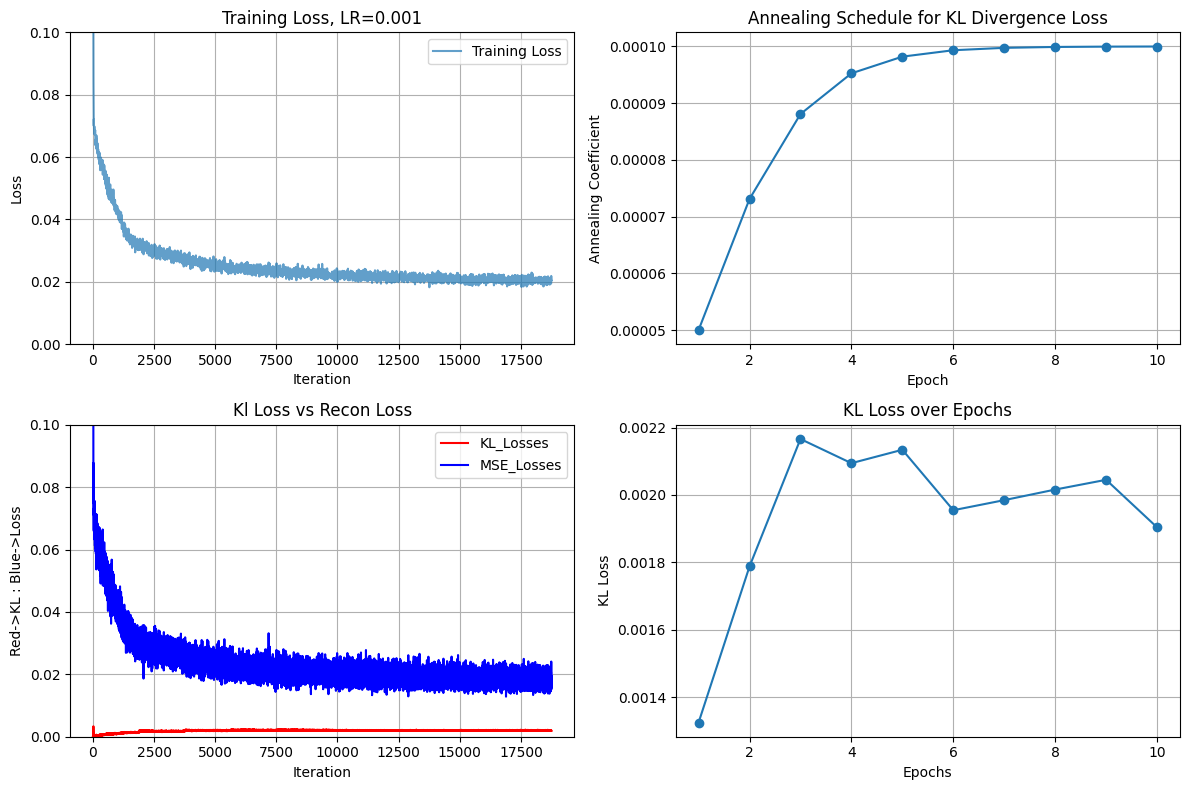

In [15]:
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

#smooth loss graph
smoothed_losses = gaussian_filter1d(losses, sigma=2)
#Graphing Area
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

#plot training loss
axes[0, 0].plot(smoothed_losses, label='Training Loss', alpha=0.7)
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_ylim(0, 0.1)
axes[0, 0].set_title("Training Loss, LR={}".format(learning_rate))
axes[0, 0].legend()
axes[0, 0].grid(True)

#plot the annealing schedule
axes[0, 1].plot(range(1, num_epochs + 1), annealing_values, marker='o', linestyle='-')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Annealing Coefficient')
axes[0, 1].set_title('Annealing Schedule for KL Divergence Loss')
axes[0, 0].legend()
axes[0, 1].grid(True)

#plot kl loss vs mse loss
axes[1, 0].plot(kl_losses, label='KL_Losses', color = 'red')
axes[1, 0].plot(mse_losses, label='MSE_Losses', color = 'blue')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Red->KL : Blue->Loss')
axes[1, 0].set_ylim(0,0.1)
axes[1, 0].set_title("Kl Loss vs Recon Loss")
axes[1, 0].legend()
axes[1, 0].grid(True)

#plot kl loss over epochs
axes[1,1].plot(range(1, num_epochs + 1), kl_epoch, marker='o', linestyle='-')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel("KL Loss")
axes[1, 1].set_title('KL Loss over Epochs')
axes[1, 1].grid(True)




plt.tight_layout()
plt.show()

In [9]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)

        x_hat, _, _ = model(x)

        break

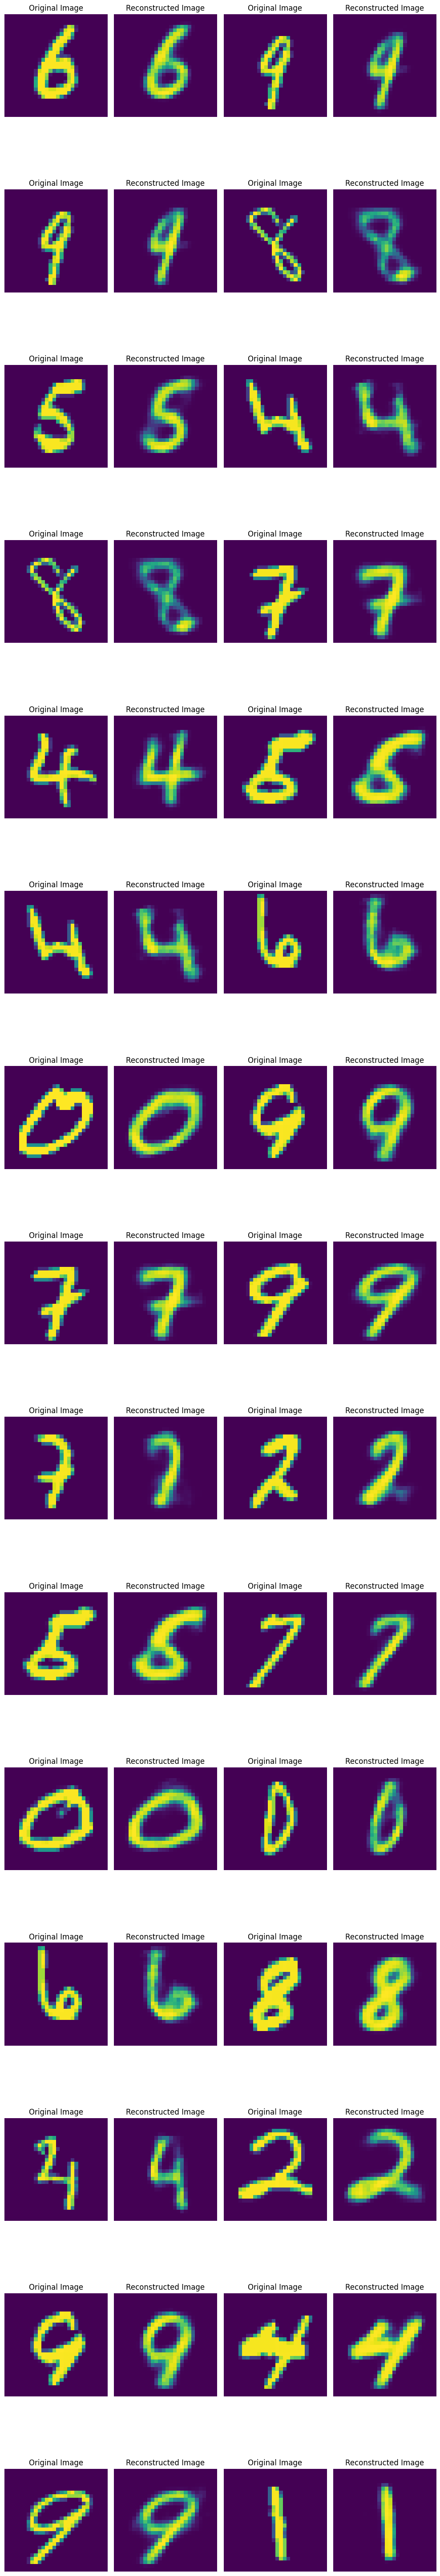

In [10]:
# make gap smaller 
fig, axes = plt.subplots(nrows=15, ncols=4, figsize=(10, 60))

for i in range(15):

    original_image = x[i].view(28, 28).cpu().numpy()
    reconstructed_image = x_hat[i].view(28, 28).cpu().numpy()
    
    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstructed_image)
    axes[i, 1].set_title('Reconstructed Image')
    axes[i, 1].axis('off')
    j = i*2+1
    original_image = x[j].view(28, 28).cpu().numpy()
    reconstructed_image = x_hat[j].view(28, 28).cpu().numpy()

    # Add your own images or modify as per your requirement
    axes[i, 2].imshow(original_image)
    axes[i, 2].set_title('Original Image')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(reconstructed_image)
    axes[i, 3].set_title('Reconstructed Image')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()